# CIRCULAR EVALUATION

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from scipy.stats import multivariate_normal as mn
from PIL import Image

In [2]:
global_factor = 4

def image_open(name):
    location='from_camera/test06/'+name+'.png'
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

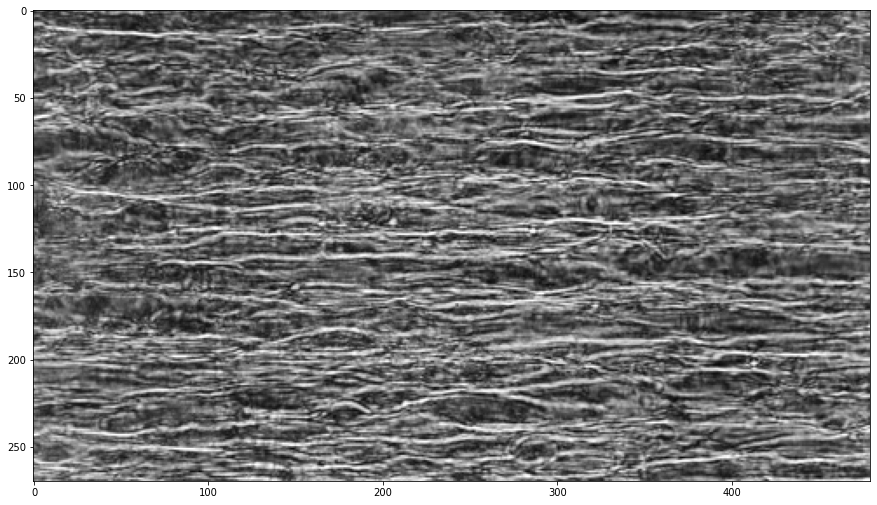

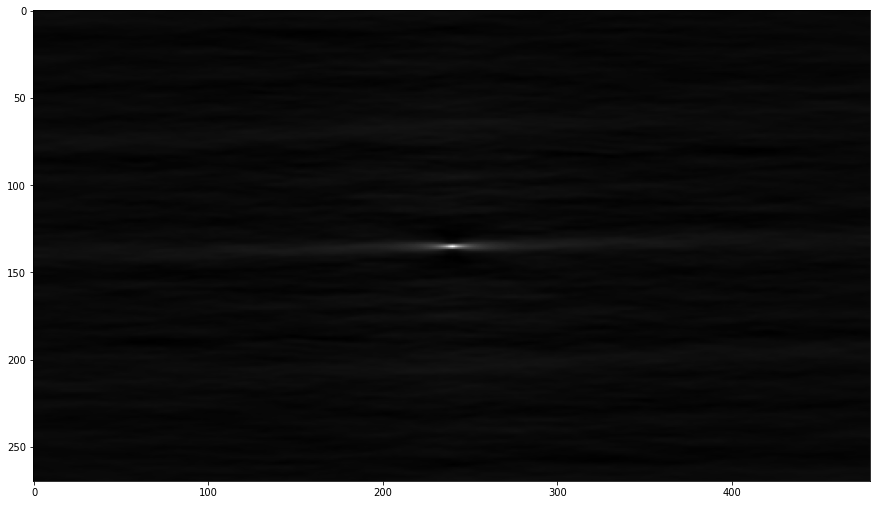

In [3]:
h = image_open('a_psf')
h -= h.mean()
plt.figure(figsize=(15,15))
plt.imshow(h,cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(signal.fftconvolve(h,np.flip(h),mode='same'),cmap='gray')
plt.show()

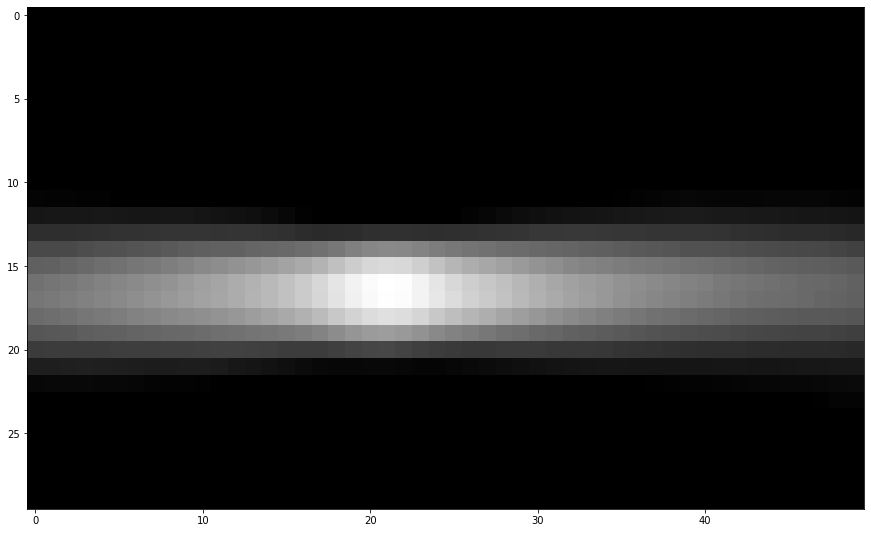

In [4]:
bigdot = image_open('b_bigdotcenter')
black = image_open('b_black1')
bigdot -= black
bigdot -= bigdot.mean()
bigdot_hat = signal.fftconvolve(bigdot,np.flip(h),mode='same')
# plt.figure(figsize=(15,15))
# plt.imshow(bigdot_hat ,cmap='gray')
# plt.show()
(sy,sx)=bigdot_hat.shape
bigdot_hat = bigdot_hat[math.floor(sy/2)+5:math.floor(sy/2)+35,math.floor(sx/2)-25:math.floor(sx/2)+25]
bigdot_hat = np.maximum(bigdot_hat,np.ones(bigdot_hat.shape))
plt.figure(figsize=(15,15))
plt.imshow(bigdot_hat ,cmap='gray')
plt.show()

## Part II _ simulation

In [5]:
def perimeter(image):
    opx=np.array([[1,0],[0,-1]])
    opy=np.array([[0,1],[-1,0]])
    image_x=signal.fftconvolve(image,opx,mode='same')
    image_y=signal.fftconvolve(image,opy,mode='same')
    image_xy=abs(image_x)+abs(image_y)
    image_xy = np.minimum(image_xy,np.ones(image_xy.shape))
    number = sum(sum(image_xy))
    plt.figure(figsize=(20,20))
    plt.imshow(image_xy,cmap='gray')
    plt.show()
    return number

def area(image):
    number = sum(sum(image))
    return number

def ratio_circularity(image):
    im_perim = perimeter(image)
    im_area = area(image)
    ratio = (im_perim**2)/(4*np.pi*im_area)
    return ratio

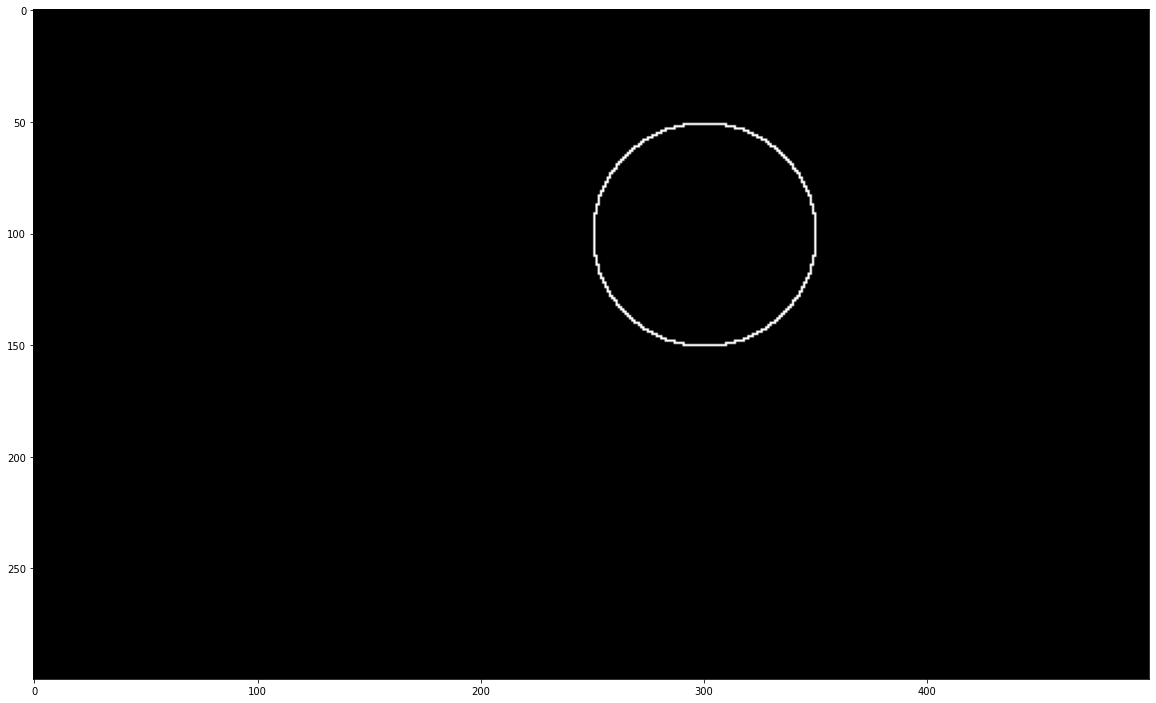

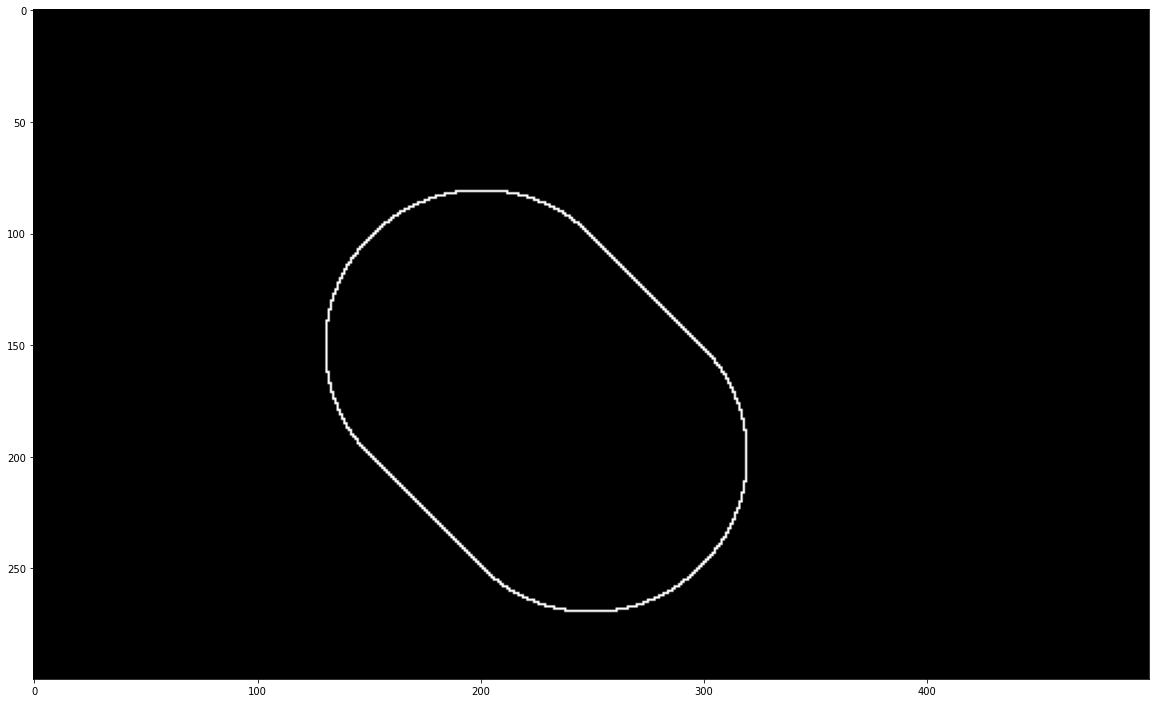

1.5947630387156708 1.7990476720684914


In [6]:
circle1 = np.zeros((300,500),dtype=float)
[rr,cc] = draw.disk((100,300),50)
circle1[rr,cc] = 1


circle2 = np.zeros((300,500),dtype=float)
for i in range(50):
    [rr,cc] = draw.disk((150+i,200+i),70)
    circle2[rr,cc] = 1

print(ratio_circularity(circle1),ratio_circularity(circle2))
# perimeter(circle2)
# plt.imshow(circle1,cmap='gray')
# plt.show()
# plt.imshow(circle2,cmap='gray')
# plt.show()

## Part 3 - PDF

In [7]:
def gauss_circularity(eigen):
    out = max(eigen)/min(eigen)
    return out

def gauss_pdf(x,u,s):
    out = np.linalg.det(2*np.pi*s)**(-0.5)*np.exp(-0.5*np.transpose(x-u)*np.invert(s)*(x-u))
    return out

(array([2., 2.]), array([[1., 0.],
       [0., 1.]]))


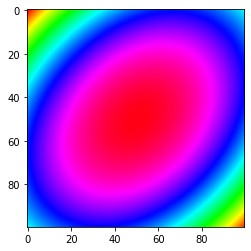

In [8]:
pdf_mm = np.zeros((100,100))
sx,sy = pdf_mm.shape
u = np.array([[50],[50]])
s=np.array([[2,0],[0,2]])
print(np.linalg.eig(s))

for i in range(sx):
    for j in range(sy):
        x = np.array([[i],[j]])
        prod = np.dot(np.dot(np.transpose(x-u),np.invert(s)),(x-u))
        # expo = np.exp(-0.5*prod)
        # out = np.linalg.det(2*np.pi*s)**(-0.5)*np.exp(-0.5*prod)

        pdf_mm[i,j] = prod

plt.imshow(pdf_mm,cmap='hsv')
plt.show()

(array([5., 5.]), array([[1., 0.],
       [0., 1.]]))


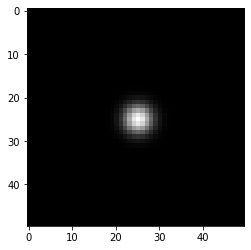

In [9]:
pdf_map = np.zeros((50,50))
sx,sy = pdf_map.shape
u = np.array([25,25])
s=np.array([[5,0],[0,5]])
print(np.linalg.eig(s))

for i in range(sx):
    for j in range(sy):
        x = np.array([i,j])
        pdf_map[i,j] = mn.pdf(x,u,s)

plt.imshow(pdf_map,cmap='gray')
plt.show()

Now, we will try to recover Σ and μ.

In [10]:
print(sum(sum(pdf_map))) # = 1, so it IS normalized.

u_a = np.array([0,0],dtype=float)
for i in range(sx):
    for j in range(sy):
        u_a += np.array([i,j])*pdf_map[i,j]

print(u_a)

s_a = np.array([[0,0],[0,0]],dtype=float)
for i in range(sx):
    for j in range(sy):
        prod = (np.array([i,j])-u_a)
        s_a += prod*prod[None].T*pdf_map[i,j]

print(s_a)

0.9999999999999999
[25. 25.]
[[5.00000000e+00 5.76541865e-17]
 [5.76541865e-17 5.00000000e+00]]
